In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'LinearModel_OneHot'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
# Create list of columns that can reasonably be one-hot-encoded
one_hot_cols = [
    'borough',
    'neighborhood',
    'zip_code',
    'tax_class_at_time_of_sale',
    'tax_class_at_present',
    'tax_class_at_present_prefix',
    'building_class_category',
    'building_class_at_time_of_sale',
    'building_class_at_time_of_sale_prefix',
    'building_class_at_present',
    'building_class_at_present_prefix'
    ]

# Create list of columns that have too many unique values
to_drop = [
    'block',
    'lot',
    'address',
    'apartment_number',
    'street_name'
    ]

In [9]:
# Define dataset parameters
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': to_drop + ['sale_price_adj'],
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': OneHotEncoder(cols=one_hot_cols),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [10]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [11]:
# Define model architecture
class LinearModel_OneHot(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define linear model
        self.TextModel = nn.Linear(dataset.X_text.shape[1], 1)

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [12]:
# Instantiate model
model = LinearModel_OneHot().to(device)

In [13]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 804


In [14]:
# Do not train if already trained
if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
    # Load optimal weights and history
    model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
    history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
    print('Skipping training and loading optimal weights from previous training!')
else:
    # Train model
    model, history = sf.train_model(
        model=model,
        dataset_train=subsets['train'],
        dataset_val=subsets['val'],

        # Define loss & optimizer
        loss_function=nn.MSELoss().to(device),
        optimizer=torch.optim.SGD(model.parameters(), lr=.0001),

        # Define computing device
        device=device,

        # Define training parameters
        epochs=100,
        patience=100,
        delta=0,
        batch_size=64,
        shuffle=True,
        num_workers=0,
        pin_memory=True,

        # Define save locations
        save_state_dict_as=f'../models/{model_name}/state_dict.pt',
        save_history_as=f'../models/{model_name}/history.csv'
        )

100%|██████████| 646/646 [00:00<00:00, 2640.01it/s]


Epoch   1/100: RMSE_train: 1,629,629, RMSE_val: 1,525,111


100%|██████████| 646/646 [00:00<00:00, 3680.49it/s]


Epoch   2/100: RMSE_train: 1,470,618, RMSE_val: 1,407,869


100%|██████████| 646/646 [00:00<00:00, 3694.13it/s]


Epoch   3/100: RMSE_train: 1,360,117, RMSE_val: 1,313,765


100%|██████████| 646/646 [00:00<00:00, 3764.46it/s]


Epoch   4/100: RMSE_train: 1,275,651, RMSE_val: 1,246,176


100%|██████████| 646/646 [00:00<00:00, 3795.98it/s]


Epoch   5/100: RMSE_train: 1,209,941, RMSE_val: 1,187,117


100%|██████████| 646/646 [00:00<00:00, 3714.61it/s]


Epoch   6/100: RMSE_train: 1,158,009, RMSE_val: 1,143,515


100%|██████████| 646/646 [00:00<00:00, 3775.48it/s]


Epoch   7/100: RMSE_train: 1,116,867, RMSE_val: 1,104,136


100%|██████████| 646/646 [00:00<00:00, 3735.12it/s]


Epoch   8/100: RMSE_train: 1,084,372, RMSE_val: 1,082,518


100%|██████████| 646/646 [00:00<00:00, 3783.84it/s]


Epoch   9/100: RMSE_train: 1,058,938, RMSE_val: 1,057,106


100%|██████████| 646/646 [00:00<00:00, 3838.95it/s]


Epoch  10/100: RMSE_train: 1,038,979, RMSE_val: 1,043,060


100%|██████████| 646/646 [00:00<00:00, 3759.61it/s]


Epoch  11/100: RMSE_train: 1,023,049, RMSE_val: 1,029,275


100%|██████████| 646/646 [00:00<00:00, 3736.91it/s]


Epoch  12/100: RMSE_train: 1,010,808, RMSE_val: 1,026,026


100%|██████████| 646/646 [00:00<00:00, 3753.00it/s]


Epoch  13/100: RMSE_train: 1,000,814, RMSE_val: 1,011,956


100%|██████████| 646/646 [00:00<00:00, 3764.70it/s]


Epoch  14/100: RMSE_train: 993,140, RMSE_val: 1,009,036


100%|██████████| 646/646 [00:00<00:00, 3788.72it/s]


Epoch  15/100: RMSE_train: 987,157, RMSE_val: 1,003,124


100%|██████████| 646/646 [00:00<00:00, 3491.49it/s]


Epoch  16/100: RMSE_train: 982,386, RMSE_val: 998,892


100%|██████████| 646/646 [00:00<00:00, 3785.82it/s]


Epoch  17/100: RMSE_train: 978,692, RMSE_val: 1,006,850
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3775.86it/s]


Epoch  18/100: RMSE_train: 975,798, RMSE_val: 994,066


100%|██████████| 646/646 [00:00<00:00, 3754.31it/s]


Epoch  19/100: RMSE_train: 973,399, RMSE_val: 996,344
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3847.23it/s]


Epoch  20/100: RMSE_train: 971,528, RMSE_val: 991,821


100%|██████████| 646/646 [00:00<00:00, 3777.29it/s]


Epoch  21/100: RMSE_train: 970,201, RMSE_val: 996,049
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3795.44it/s]


Epoch  22/100: RMSE_train: 968,972, RMSE_val: 992,137
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 3772.76it/s]


Epoch  23/100: RMSE_train: 968,074, RMSE_val: 989,775


100%|██████████| 646/646 [00:00<00:00, 3835.13it/s]


Epoch  24/100: RMSE_train: 967,312, RMSE_val: 994,017
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3773.01it/s]


Epoch  25/100: RMSE_train: 966,601, RMSE_val: 999,895
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 3746.82it/s]


Epoch  26/100: RMSE_train: 966,225, RMSE_val: 989,452


100%|██████████| 646/646 [00:00<00:00, 3796.49it/s]


Epoch  27/100: RMSE_train: 965,590, RMSE_val: 989,845
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3777.78it/s]


Epoch  28/100: RMSE_train: 965,291, RMSE_val: 990,771
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 3800.58it/s]


Epoch  29/100: RMSE_train: 965,039, RMSE_val: 993,370
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 3498.02it/s]


Epoch  30/100: RMSE_train: 964,871, RMSE_val: 991,153
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 3001.41it/s]


Epoch  31/100: RMSE_train: 964,636, RMSE_val: 989,664
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 3519.94it/s]


Epoch  32/100: RMSE_train: 964,302, RMSE_val: 997,057
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 3666.60it/s]


Epoch  33/100: RMSE_train: 964,233, RMSE_val: 989,736
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 3685.62it/s]


Epoch  34/100: RMSE_train: 964,007, RMSE_val: 1,002,450
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 3667.89it/s]


Epoch  35/100: RMSE_train: 963,910, RMSE_val: 992,347
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 3728.14it/s]


Epoch  36/100: RMSE_train: 963,752, RMSE_val: 998,765
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 3756.29it/s]


Epoch  37/100: RMSE_train: 963,676, RMSE_val: 989,645
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 3687.30it/s]


Epoch  38/100: RMSE_train: 963,713, RMSE_val: 992,995
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 3710.94it/s]


Epoch  39/100: RMSE_train: 963,649, RMSE_val: 989,478
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 3728.41it/s]


Epoch  40/100: RMSE_train: 963,444, RMSE_val: 992,856
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 3696.90it/s]


Epoch  41/100: RMSE_train: 963,365, RMSE_val: 994,180
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 3639.89it/s]


Epoch  42/100: RMSE_train: 963,452, RMSE_val: 990,880
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 3454.10it/s]


Epoch  43/100: RMSE_train: 963,191, RMSE_val: 990,195
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 3689.27it/s]


Epoch  44/100: RMSE_train: 963,255, RMSE_val: 990,587
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 3690.22it/s]


Epoch  45/100: RMSE_train: 963,143, RMSE_val: 993,346
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 3673.02it/s]


Epoch  46/100: RMSE_train: 963,159, RMSE_val: 1,001,924
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 3690.75it/s]


Epoch  47/100: RMSE_train: 962,985, RMSE_val: 1,000,608
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 3744.60it/s]


Epoch  48/100: RMSE_train: 962,965, RMSE_val: 995,934
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 3665.97it/s]


Epoch  49/100: RMSE_train: 962,994, RMSE_val: 990,177
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 3693.22it/s]


Epoch  50/100: RMSE_train: 962,870, RMSE_val: 990,121
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 3680.64it/s]


Epoch  51/100: RMSE_train: 962,748, RMSE_val: 992,272
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 3717.71it/s]


Epoch  52/100: RMSE_train: 962,691, RMSE_val: 989,106


100%|██████████| 646/646 [00:00<00:00, 3649.58it/s]


Epoch  53/100: RMSE_train: 962,922, RMSE_val: 991,677
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3491.95it/s]


Epoch  54/100: RMSE_train: 962,741, RMSE_val: 992,418
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 3698.04it/s]


Epoch  55/100: RMSE_train: 962,733, RMSE_val: 995,162
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 3694.64it/s]


Epoch  56/100: RMSE_train: 962,639, RMSE_val: 990,888
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 3727.49it/s]


Epoch  57/100: RMSE_train: 962,560, RMSE_val: 992,642
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 3700.08it/s]


Epoch  58/100: RMSE_train: 962,565, RMSE_val: 990,246
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 3739.20it/s]


Epoch  59/100: RMSE_train: 962,531, RMSE_val: 989,928
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 3699.88it/s]


Epoch  60/100: RMSE_train: 962,408, RMSE_val: 989,307
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 3764.50it/s]


Epoch  61/100: RMSE_train: 962,411, RMSE_val: 994,568
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 3745.54it/s]


Epoch  62/100: RMSE_train: 962,330, RMSE_val: 995,032
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 3756.40it/s]


Epoch  63/100: RMSE_train: 962,326, RMSE_val: 992,882
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 3795.45it/s]


Epoch  64/100: RMSE_train: 962,274, RMSE_val: 989,306
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 3326.63it/s]


Epoch  65/100: RMSE_train: 962,519, RMSE_val: 989,491
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 3671.58it/s]


Epoch  66/100: RMSE_train: 962,215, RMSE_val: 990,607
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 3720.70it/s]


Epoch  67/100: RMSE_train: 962,394, RMSE_val: 991,940
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 3716.94it/s]


Epoch  68/100: RMSE_train: 962,343, RMSE_val: 989,440
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 3693.62it/s]


Epoch  69/100: RMSE_train: 962,148, RMSE_val: 988,802


100%|██████████| 646/646 [00:00<00:00, 3695.12it/s]


Epoch  70/100: RMSE_train: 962,154, RMSE_val: 988,951
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3771.36it/s]


Epoch  71/100: RMSE_train: 962,039, RMSE_val: 987,424


100%|██████████| 646/646 [00:00<00:00, 3728.43it/s]


Epoch  72/100: RMSE_train: 962,149, RMSE_val: 989,257
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3685.30it/s]


Epoch  73/100: RMSE_train: 962,069, RMSE_val: 988,378
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 3724.02it/s]


Epoch  74/100: RMSE_train: 962,106, RMSE_val: 993,317
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 3827.64it/s]


Epoch  75/100: RMSE_train: 962,073, RMSE_val: 991,689
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 3766.98it/s]


Epoch  76/100: RMSE_train: 962,070, RMSE_val: 986,993


100%|██████████| 646/646 [00:00<00:00, 3688.49it/s]


Epoch  77/100: RMSE_train: 962,050, RMSE_val: 990,486
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3246.20it/s]


Epoch  78/100: RMSE_train: 961,971, RMSE_val: 986,981


100%|██████████| 646/646 [00:00<00:00, 3698.55it/s]


Epoch  79/100: RMSE_train: 961,889, RMSE_val: 987,745
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3737.02it/s]


Epoch  80/100: RMSE_train: 961,934, RMSE_val: 986,682


100%|██████████| 646/646 [00:00<00:00, 3692.98it/s]


Epoch  81/100: RMSE_train: 961,984, RMSE_val: 993,689
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3692.11it/s]


Epoch  82/100: RMSE_train: 961,982, RMSE_val: 986,229


100%|██████████| 646/646 [00:00<00:00, 3720.60it/s]


Epoch  83/100: RMSE_train: 961,827, RMSE_val: 986,123


100%|██████████| 646/646 [00:00<00:00, 3735.07it/s]


Epoch  84/100: RMSE_train: 961,829, RMSE_val: 989,198
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3742.34it/s]


Epoch  85/100: RMSE_train: 961,795, RMSE_val: 986,443
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 3726.33it/s]


Epoch  86/100: RMSE_train: 961,691, RMSE_val: 986,349
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 3718.73it/s]


Epoch  87/100: RMSE_train: 961,670, RMSE_val: 986,368
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 3698.64it/s]


Epoch  88/100: RMSE_train: 961,761, RMSE_val: 986,203
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 3717.09it/s]


Epoch  89/100: RMSE_train: 961,688, RMSE_val: 990,854
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 3217.99it/s]


Epoch  90/100: RMSE_train: 961,635, RMSE_val: 987,990
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 3713.86it/s]


Epoch  91/100: RMSE_train: 961,651, RMSE_val: 987,328
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 3772.37it/s]


Epoch  92/100: RMSE_train: 961,625, RMSE_val: 985,197


100%|██████████| 646/646 [00:00<00:00, 3705.36it/s]


Epoch  93/100: RMSE_train: 961,630, RMSE_val: 986,611
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3704.96it/s]


Epoch  94/100: RMSE_train: 961,535, RMSE_val: 985,319
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 3741.09it/s]


Epoch  95/100: RMSE_train: 961,500, RMSE_val: 985,023


100%|██████████| 646/646 [00:00<00:00, 3757.81it/s]


Epoch  96/100: RMSE_train: 961,660, RMSE_val: 984,643


100%|██████████| 646/646 [00:00<00:00, 3746.79it/s]


Epoch  97/100: RMSE_train: 961,573, RMSE_val: 985,936
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 3734.08it/s]


Epoch  98/100: RMSE_train: 961,470, RMSE_val: 985,504
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 3750.80it/s]


Epoch  99/100: RMSE_train: 961,444, RMSE_val: 985,514
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 3705.06it/s]


Epoch 100/100: RMSE_train: 961,488, RMSE_val: 988,003
EarlyStopping counter: 4 out of 100


In [15]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [16]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   959866.897  544888.198  0.825  0.409
val     987793.981  546411.766  0.816  0.363
test    967874.209  543713.164  0.785  0.395
--------------------------------------------
total   964297.832  544805.536  0.816  0.402


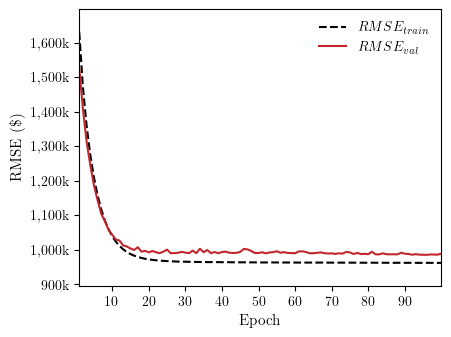

In [17]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

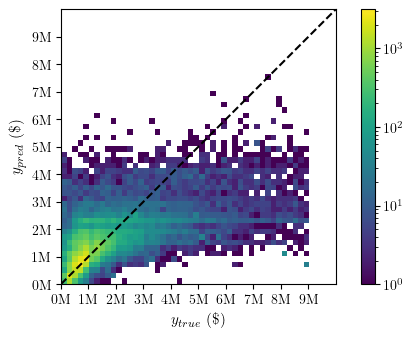

In [18]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')